# Contextual Bandit

In [1]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import copy
from dataclasses import dataclass, field
from jax import random, jit
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from numpyro.distributions import constraints
from numpyro.optim import Adam


rng_key = random.PRNGKey(12345)

In [2]:
@dataclass
class State:
    mood: [int] = field(default_factory=list)
    weather: [int] = field(default_factory=list)
    arms: [int] = field(default_factory=list)
    rewards: [int] = field(default_factory=list)


def update(state: State, arm: int, mood: int, weather: int, reward: int) -> State:
    """Update the state with the new arm, mood, weather, and reward"""
    s = copy.deepcopy(state)
    s.mood.append(mood)
    s.weather.append(weather)
    s.arms.append(arm)
    s.rewards.append(reward)
    return s

In [3]:
invlogit = lambda x: 1 / (1 + jnp.exp(-x))


def model(mood, weather, arm, obs=None):
    alpha_0 = numpyro.sample(
        "alpha_0", 
        dist.Normal(0, 1.5)
    )
    alpha_mood = numpyro.sample(
        "alpha_mood", 
        dist.Normal(0, 2).expand((2, 4))
    )
    alpha_weather = numpyro.sample(
        "alpha_weather", 
        dist.Normal(0, 2).expand((2, 4))
    )

    logit_p = alpha_0 + alpha_mood[mood, arm] + alpha_weather[weather, arm]
    theta = numpyro.deterministic("theta", invlogit(logit_p))
    numpyro.sample("obs", dist.Binomial(probs=theta), obs=obs)


def estimate_parameters(rng_key, state: State) -> Predictive:
    """Estimate the parameters of the model using MCMC"""
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1, progress_bar=False)    
    mcmc.run(rng_key, obs=jnp.array(state.rewards), arm=state.arms, mood=state.mood, weather=state.weather)
    predictive = Predictive(model, mcmc.get_samples())
    return predictive


class ContextualThompsonSampling:
    @classmethod
    def get_arm(cls, rng_key, predictive: Predictive, mood: int, weather: int) -> int:
        pred = predictive(rng_key, arm=[0, 1, 2, 3], mood=jnp.array([mood]), weather=jnp.array([weather]))
        n, d = pred['theta'].shape
        theta = pred['theta'][np.random.randint(0, n)]  # Sample a random theta
        arm = np.argmax(theta)
        return arm

    @classmethod
    def print_theta(self, rng_key, predictive: Predictive):
        mw = [(0, 0), (0, 1), (1, 0), (1, 1)]
        thetas = []
        for m, w in mw:
            rng_key, rng_key_ = random.split(rng_key)
            pred = predictive(rng_key_, arm=[0, 1, 2, 3], mood=jnp.array([m]), weather=jnp.array([w]))
            thetas.append(jnp.mean(pred['theta'], axis=0))
        thetas = jnp.array(thetas)
        print(thetas)

In [4]:
class Environment:
    def __init__(self, thetas: np.array, moods: np.array, weathers: np.array):
        self.thetas = thetas
        self.moods = moods  # 0: active, 1: chill
        self.weathers = weathers  # 0: rainy, 1: sunny

    def get_context(self):
        """Randomly sample a mood and weather"""
        mood = np.random.choice(self.moods)
        weather = np.random.choice(self.weathers)
        return mood, weather


def react(env: Environment, arm: int, mood: int, weather: int) -> int:
    """Return a reward based on the arm, mood, and weather"""
    idx = mood * 2 + weather
    theta = env.thetas[idx]

    if np.random.random() < theta[arm]:
        return 1
    else:
        return 0

In [5]:
moods = jnp.array([0, 1])
weathers = jnp.array([0, 1])
thetas = jnp.array([[1e-3, 1e-3, 0.60, 0.40],  # active, rainy
                    [0.60, 0.20, 1e-3, 0.20],  # active, sunny
                    [1e-3, 1e-3, 0.20, 0.80],  # chill, rainy
                    [0.20, 0.60, 1e-3, 0.20]])  # chill, sunny

env = Environment(thetas, moods, weathers)
state = State()

rng_key, rng_key_ = random.split(rng_key)
predictive = estimate_parameters(rng_key_, state)
num_trials = 100

for i in range(num_trials):
    if i % 10 == 0:
        print(f"Iteration {i}")
        rng_key, rng_key_ = random.split(rng_key)
        predictive = estimate_parameters(rng_key_, state)

    mood, weather = env.get_context()
    rng_key, rng_key_ = random.split(rng_key)
    arm = ContextualThompsonSampling.get_arm(rng_key_, predictive, mood, weather)
    reward = react(env, arm, mood, weather)
    state = update(state, arm, mood, weather, reward)


Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


In [6]:
rng_key, rng_key_ = random.split(rng_key)
ContextualThompsonSampling.print_theta(rng_key_, predictive)

# The thetas that we defined.
# thetas = jnp.array([[1e-3, 1e-3, 0.60, 0.40],  # active, rainy
#                     [0.60, 0.20, 1e-3, 0.20],  # active, sunny
#                     [1e-3, 1e-3, 0.20, 0.80],  # chill, rainy
#                     [0.20, 0.60, 1e-3, 0.20]])  # chill, sunny

[[0.24391429 0.02098811 0.71415615 0.1727861 ]
 [0.74175525 0.14414038 0.12038788 0.07808025]
 [0.03451755 0.11843649 0.19726005 0.25396854]
 [0.23639394 0.56845623 0.01718167 0.11933458]]


In [7]:
for i in range(10):
    m, w = env.get_context()
    pred = predictive(rng_key=rng_key, arm=[0, 1, 2, 3], mood=jnp.array([m]), weather=jnp.array([w]))
    n, d = pred['theta'].shape
    theta = pred['theta'][np.random.randint(0, n)]  # Sample a random theta
    arm = np.argmax(theta)
    print(f"mood: {m}, weather: {w}, arm: {arm}, theta: {theta[arm]}")


mood: 0, weather: 1, arm: 0, theta: 0.6492186784744263
mood: 0, weather: 0, arm: 2, theta: 0.5419777631759644
mood: 1, weather: 1, arm: 1, theta: 0.49977657198905945
mood: 0, weather: 1, arm: 0, theta: 0.5581031441688538
mood: 1, weather: 1, arm: 1, theta: 0.6102959513664246
mood: 0, weather: 1, arm: 0, theta: 0.7430512309074402
mood: 1, weather: 0, arm: 3, theta: 0.26443201303482056
mood: 1, weather: 0, arm: 3, theta: 0.40771448612213135
mood: 0, weather: 0, arm: 2, theta: 0.6394892334938049
mood: 1, weather: 1, arm: 1, theta: 0.4543297290802002


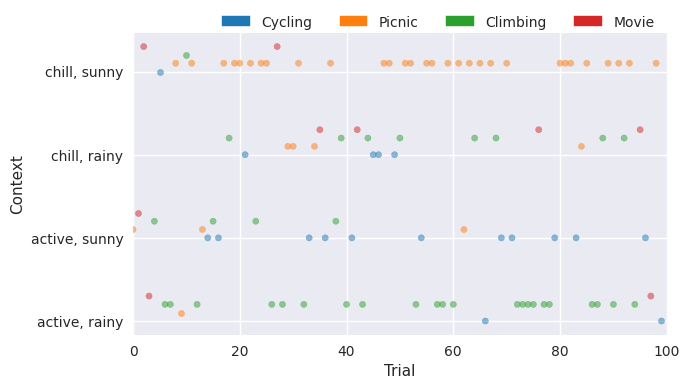

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


# Plot a scatter plot of which arm was chosen at each time step
arm_index = [0, 1, 2, 3]
arm_descriptions = ["Cycling", "Picnic", "Climbing", "Movie"]
contexts = [(0, 0), (0, 1), (1, 0), (1, 1)]
context_descriptions = ["active, rainy", "active, sunny", "chill, rainy", "chill, sunny"]
arm_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Plot the arm choices
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

c2i = lambda m, w: m * 2 + w


for m, w in contexts:
    for ai, arm in enumerate(arm_index):
        x, y, c = [], [], []
        for i in range(len(state.arms)):            
            if state.mood[i] == m and state.weather[i] == w and state.arms[i] == arm:
                x.append(i)
                y.append(c2i(m, w) + ai * 0.1)
                c.append(arm_colors[arm])
        ax.scatter(x, y, c=c, s=20, alpha=0.5)
    
ax.set_yticks(range(len(contexts)), context_descriptions)
ax.set_ylabel("Context")
ax.set_xlabel("Trial")
ax.set_xlim([0, 100])

handles = []
for arm in arm_index:
    h = mpatches.Patch(color=arm_colors[arm], label=arm_descriptions[arm])
    handles.append(h)
plt.legend(handles=handles, bbox_to_anchor=(1., 1.1), loc="upper right", ncols=4)
plt.tight_layout()
plt.show()

In [ ]:
thetas